In [66]:
import numpy as np
import scipy.io as scio
import random
import matplotlib.pyplot as plt              
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.decomposition import PCA   
from torch.autograd import Variable
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from copy import deepcopy

In [67]:
# load data, return data and labels
class PineDataset(Dataset):
    def __init__(self, datas, labels, transform=None, target_transform=None):
        self.datas = datas
        self.labels = labels
        self.labels = torch.Tensor(labels).long()
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        data = self.datas[index]
        label = self.labels[index]

        if self.transform is not None:
            data = self.transform(data)                         
        return data, label
    
    def __len__(self):
        return self.datas.shape[0]

In [68]:
epochs = 30
number_classes = 17     # refers to the number of classes in the HSI data
patch_size = 5                        
features_num = 140      # refers to the number of features or channels in each patch of the HSI data, features_num mean the total number of bands(each pixel) or channels considered for classification.                   
batch_size = 4096
lr = 1e-3               # learning rated
rate = 0.7              # training data ratio

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Indian Pines is a Hyperspectral image dataset.
- The input data consists of hyperspectral bands over a single landscape in Indiana, US, (Indian Pines dataset) with 145×145 pixels. 
- For each pixel, the data set contains 224 spectral reflectance bands which represent different portions of the electromagnetic spectrum in the wavelength range 0.4–2.5 10^(-6) meters. 
- The Indian Pines scene contains two-thirds agriculture, and one-third forest or other natural perennial vegetation. There are two major dual lane highways, a rail line, as well as some low density housing, other built structures, and smaller roads.
- The ground truth available is designated into sixteen classes.
- We have also reduced the number of bands to 200 by removing bands covering the region of water absorption: [104-108], [150-163]

In [69]:
# HSI data is typically represented as a 3D array, where the dimensions correspond to spatial information (rows and columns) and spectral bands (channels).

data_path = './data/Indian_pines_corrected.mat'
label_path = './data/Indian_pines_gt.mat'
data = scio.loadmat(data_path)['indian_pines_corrected']
origin_label = scio.loadmat(label_path)['indian_pines_gt']

label = origin_label.flatten()
shape = data.shape

| #                             |  Class                                   |  Samples
| :------:                          | :------:                                  | :-------------:   |
| 1                          | Alfalfa  |          46         |
| 2                      | Corn-notill     |         1428          |
| 3               | Corn-mintill             |       830            |
| 4                  | Corn             | 237          |
| 5            | Grass-pasture                   |      483             |
| 6  | Grass-tree                             |       730            |
| 7        | Grass-pasture-mowed                             | 28     |
| 8                  | Hay-windrowed                             | 478   |
| 9       | Oats                                      |         20          |
| 10                  | Soybean-notill                                      | 972  |
| 11                          | Soybean-mintill                                      | 2455       |
| 12                          | Soybean-clean                                      | 593       |
| 13                         | Wheat                                      | 205       |
| 14                          | Woods                                      | 1265       |
| 15                          |Buildings-Grass-Trees-Drives                    |  386    |
| 16                          | Stone-Steel-Towers                                      |    93    |

In [70]:
# PCA
data = data.reshape(-1, 200)            # converts the 3D array to a 2D array, the second is fixed size of 200. The first is -1, which automatically calculates the appropriate size based on the original data shape.
pca = PCA(n_components=features_num)    # n_components เอาไว้ระบุจำนวน components ที่สำคัญที่สุดที่จะใช้ ในที่นี้เราใช้ 140 components แทนที่จะใช้ 200 components ทั้งหมด (spectral bands)
data = pca.fit_transform(data)          # ลด dimension โดยยังคงข้อมูลที่สำคัญที่ถูกรวบรวมด้วย principal components

# 2D array represents the spectral information of the HSI data, where each row corresponds to a single pixel and each column represents a spectral band.

In [71]:
# reshaping the data array before padding helps to establish the desired structure and dimensions for the data.
print(data.shape)
data = data.reshape(shape[0], shape[1], data.shape[1])  # converts the 2D array to a 3D array (height-pixel, width-pixel, spectral band)
print(data.shape)

(21025, 140)
(145, 145, 140)


In [72]:
# Padding (คงขนาด input ไว้เพื่อให้เหมาะสมกับการใช้ CNN, การทำ padding จะช่วยให้เราสามารถ patch ได้โดยไม่มีปัญหาเรื่องขนาดภาพ, ขอบเขตภาพ)
# ถ้าเราไม่ทำ padding เมื่อใช้ CNN อาจเกิดปัญหาเกี่ยวกับข้อมูลของภาพ โดยเฉพาะเมื่อเราใช้ kernel (filter) ที่มีขนาดใหญ่กว่า 1x1 และมี stride (การเคลื่อนที่ของ kernel) ที่มากกว่า 1 เนื่องจาก kernel คำนวณนอกเขตภาพไม่ได้
padding = int(patch_size / 2)
data = np.pad(data, ((padding, padding), (padding, padding), (0, 0)), 'edge')       # pad the height and width dimensions, spectral bands are not padded ('edge' pad โดยใช้ขอบของรูปต้นฉบับ)

# Patch (แบ่งรูปภาพใหญ่เป็นส่วนย่อยเล็กๆ ที่มีขนาดเท่ากัน)
data_patchs = []
for y in range(padding, data.shape[0]-padding):
    for x in range(padding, data.shape[1]-padding):
        data_patchs.append(data[y - padding: y + padding + 1, x - padding: x + padding + 1, :])     # เเบ่งรูปภาพใหญ่เป็นส่วนย่อยเล็กๆ ที่มีขนาดเท่าๆกัน (: = เอา spectral band ทั้งหมด)
data_patchs = np.array(data_patchs, dtype='float32')        
data_patchs_test = deepcopy(data_patchs)

In [74]:
print(label)

[3 3 3 ... 0 0 0]


In [75]:
# count the data of various pixels, 17 categories (0-16)
data_class = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[], 10:[], 11:[], 0:[], 12:[], 13:[], 14:[], 15:[], 16:[]}    # [] data patches for each category
for i in range(label.shape[0]):
    data_class[label[i]].append(data_patchs[i])

# scramble data (ensure that the model does not rely solely on spatial patterns or positional information)
for key in data_class:
    random.shuffle(data_class[key])

In [76]:
# สร้าง training set เเละ test set
train_datas = []
train_labels = []
test_datas = []
test_labels = []

for key in data_class:
    train_num = int(data_class[key].__len__() * rate)    # get the number of samples used for training in the current class
    for j in range(data_class[key].__len__()):           # split the current sample to training set and test set
        if j < train_num:
            train_datas.append(data_class[key][j])
            train_labels.append(key)
        else:
            test_datas.append(data_class[key][j])
            test_labels.append(key)
train_datas = np.array(train_datas, dtype='float32')
train_labels = np.array(train_labels)
test_datas = np.array(test_datas, dtype='float32')
test_labels = np.array(test_labels)

In [77]:
class Classification(nn.Module):
    def __init__(self, number_classes, in_channels):
        super(Classification, self).__init__()
        # The first layer 
        self.out1 = nn.Sequential(
            # input features_num channel two-dimensional tensor, 32 convolution kernels, kernel size 3*3
            nn.Conv2d(in_channels, 32, kernel_size=3, stride=1, padding=1),                                 # output 32 feature maps
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1),
            # input 32-channel two-dimensional tensor, 64 convolution kernels, kernel size 3*3
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),                                          # input 32 feature maps, output 64 feature maps
            nn.BatchNorm2d(64),                                                                             # batch normalization ช่วยลดการกระจายตัวของข้อมูล, ลดปัญหาการเกิด gradient exploding หรือ vanishing gradient 
            nn.LeakyReLU(0.1),
        )
        # The second layer 
        self.out2 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=1),      # kernel size 1*1
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
        )
        # The last layer
        self.output = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*patch_size*patch_size, 128),       # 64 * patch_size * patch_size input features, and it reduces the dimensionality to 128
            nn.LeakyReLU(0.1),
            nn.Linear(128, number_classes),                 # maps the 128-dimensional feature representation to the number_classes output classes, fully connected layer
        )

    def forward(self, x):
        out1 = self.out1(x)                                                 
        out2 = self.out2(x)
        output = out1 + out2
        output = self.output(output)
        return output

In [78]:
model = Classification(number_classes, features_num).to(device)
print(model)
# make loss function
lossFun = nn.CrossEntropyLoss() # cross entropy loss function

# optimizer is used to optimize the model parameters during training
optimizer = optim.Adam(model.parameters(),lr=lr)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)             # ใช้เพื่อปรับ learning rate ของ optimizer ตามจำนวน epochs ที่ผ่านมา เพื่อช่วยให้โมเดลเรียนรู้ได้ดีขึ้น

# training data preparation
transform = transforms.Compose([transforms.ToTensor(), ])                                       # applying a sequence of transformations
pine_train = PineDataset(train_datas, train_labels, transform=transform)                        # converts the input data to PyTorch tensors
data_loader_train = DataLoader(pine_train, batch_size=batch_size, shuffle=True)

# test data preparation
transform = transforms.Compose([transforms.ToTensor(), ])
pine_test = PineDataset(test_datas, test_labels, transform=transform)
data_loader_test = DataLoader(pine_test, batch_size=batch_size, shuffle=False)

# training model
loss_epochs_train = []          # average loss per epoch during training
loss_epochs_test = []
epochs_num = []                 # display number of epochs
train_acc = []
test_acc = []

print('start training......')

for epoch in range(epochs):
    model.train()                                                       # set the model to training mode, enabling features like dropout or batch normalization                                         
    loss_train = []                                                     # store the training loss for each batch

    for index, (images, labels) in enumerate(data_loader_train):
        images_cuda = Variable(images).to(device)                       # load image into cuda
        model_output = model(images_cuda)                               # forward propagation, the output size is (batch size, number_classes)
        labels_cuda = Variable(labels).to(device)                       # load labels into cuda
        labels_cuda = labels_cuda.long()  
        loss = lossFun(model_output, labels_cuda)                       # calculate loss between model's output and the ground truth labels
        optimizer.zero_grad()                                           # clear the gradient
        loss.backward()                                                 # backpropagation, computed gradients
        optimizer.step()                                                # optimizer update model parameters
        loss_train.append(loss.data.item())
        # print('epoch:{}, batch:{}, loss:{:.6f}'.format(epoch+1, index+1, loss.data.item()))

    scheduler.step()                                                    # adjust the learning rate of the optimizer according to the epoch
    
    model.eval()                                           
    val_correct = 0
    train_correct = 0

    for index, (images, labels) in enumerate(data_loader_train):
        images_cuda = Variable(images).to(device)          
        model_output   = model(images_cuda)                   
        labels_cuda = Variable(labels).to(device)
        pred = torch.argmax(F.softmax(model_output, dim=1), dim=1)      # get the index of the max probability
        train_correct += torch.eq(pred, labels_cuda).sum().item()       # the number of correct predictions is calculated by comparing the predictions with the ground truth labels (labels_cuda) and summing the matches

    loss_test = []
    for index, (images, labels) in enumerate(data_loader_test):
        images_cuda = Variable(images).to(device)         
        model_output = model(images_cuda)                   
        labels_cuda = Variable(labels).to(device)         
        labels_cuda = labels_cuda.long()  
        loss = lossFun(model_output, labels_cuda)  

        pred = torch.argmax(model_output, dim=1)
        val_correct += torch.eq(pred, labels_cuda).sum().item()

        loss_test.append(loss.data.item())

    # record loss, accuracy and epoch number
    loss_epochs_train.append(np.mean(loss_train))
    loss_epochs_test.append(np.mean(loss_test))
    train_acc.append(train_correct / len(train_datas))
    test_acc.append(val_correct / len(test_datas))
    epochs_num.append(epoch+1)

    print("epoch: {}".format(epoch))
    print("Train set: loss = {0:.8f}， acc = {1:.2f}%".format(loss_epochs_train[-1], train_acc[-1]*100))
    print("Val set: loss = {0:.8f}， acc = {1:.2f}%".format(loss_epochs_test[-1], test_acc[-1]*100))

    # การ reset optimizer's gradient เพราะ pytorch จะสะสม gradient ทุกครั้งที่เรียก backward() ในเเต่ละ batch ซึ่งอาจจะทำให้เกิดการ update parameter ที่ไม่ถูกต้อง
    
    # Backpropagation is the process of computing the gradients of the loss function with respect to the model's parameters. It involves two main steps:
    # - calculating the gradient of the loss with respect to the output of the network
    # - then propagating these gradients backward through the layers to compute the gradients with respect to the weights and biases of each layer.

Classification(
  (out1): Sequential(
    (0): Conv2d(140, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.1)
  )
  (out2): Sequential(
    (0): Conv2d(140, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
  )
  (output): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1600, out_features=128, bias=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Linear(in_features=128, out_features=17, bias=True)
  )
)
start training...
epoch: 0
Train set: loss = 2.04117352， acc = 55.24%
Val set: loss = 1.82540584， acc 

In [79]:
torch.save(model.state_dict(), './model/model.pth')
torch.save(optimizer.state_dict(), './model/optimizer.pth')

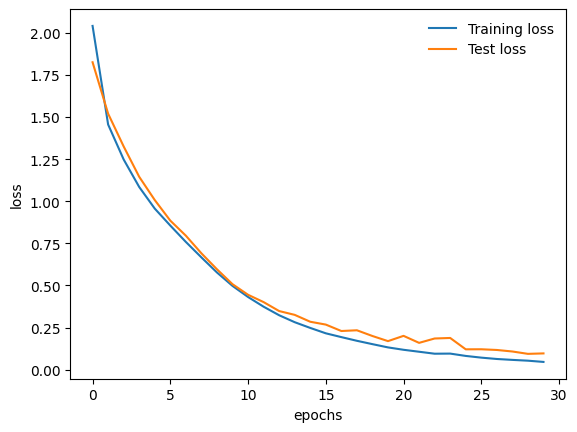

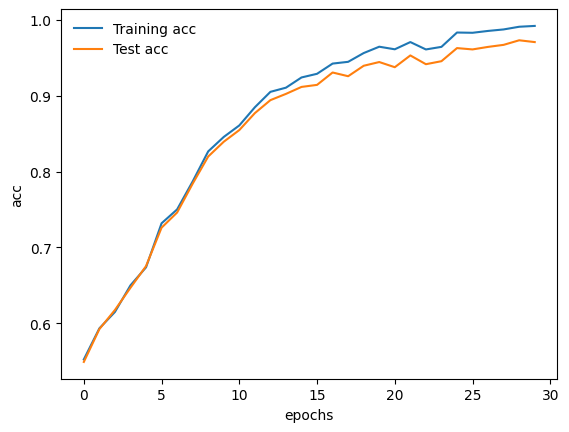

In [80]:
plt.figure('loss')
plt.plot(loss_epochs_train, label='Training loss')
plt.plot(loss_epochs_test, label='Test loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(frameon=False)

plt.figure('acc')
plt.plot(train_acc, label='Training acc')
plt.plot(test_acc, label='Test acc')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.legend(frameon=False)

plt.show()

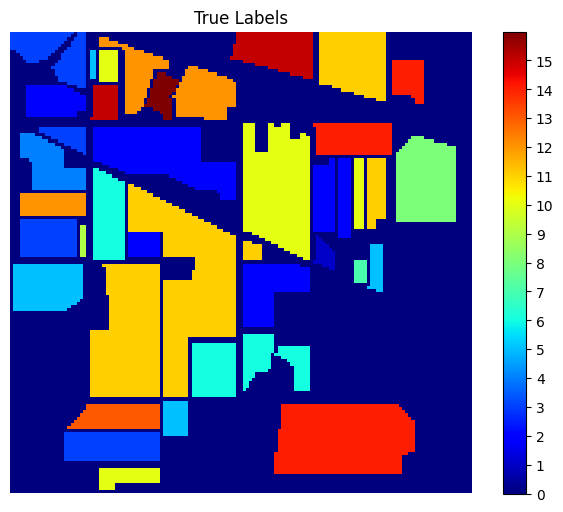

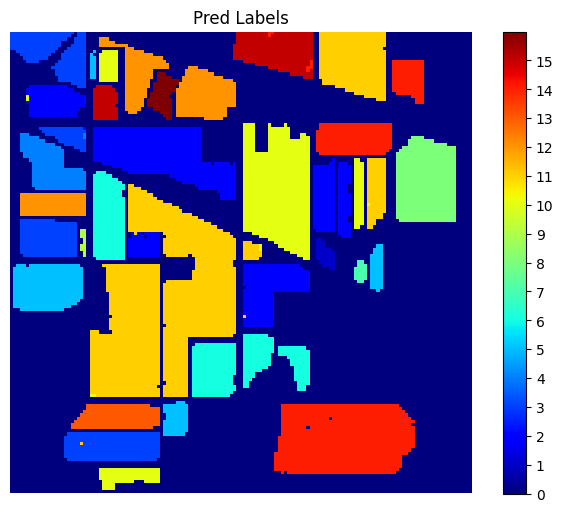

In [81]:
plt.figure(figsize=(8, 6))
plt.imshow(origin_label, cmap='jet')
plt.axis('off')
plt.colorbar(ticks=range(0,16))
plt.title("True Labels")
plt.show()

model.eval()
data_patchs_test_tensor = []
trans = transforms.ToTensor()
for i in range(21025):
    data_patchs_test_tensor.append(trans(data_patchs_test[i]))
data_patchs_test_tensor = torch.stack(data_patchs_test_tensor).to(device)
with torch.no_grad():
    pred_label = model(data_patchs_test_tensor)
    pred_label = torch.argmax(F.softmax(pred_label, dim=1), dim=1).cpu().numpy().flatten()

origin_label = origin_label.flatten()
for i in range(21025):
    if origin_label[i] == 0:
        pred_label[i] = 0

pred_label = pred_label.reshape(shape[0], shape[1])

plt.figure(figsize=(8, 6))
plt.imshow(pred_label, cmap='jet')
plt.axis('off')
plt.colorbar(ticks= range(0,16))
plt.title("Pred Labels")
plt.show()